# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sn

# Choose options ang configurate
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True


To download the dataset you must specify your user and key for kaggle (Dataset weight 5 GBs, so it takes a time to download)

In [2]:
PROCESS_IMAGES = False
PROCESS_DATA = True

DOWNLOAD_DATA = False
if DOWNLOAD_DATA:
    os.environ['KAGGLE_USERNAME'] = "xxxxxx"
    os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxx"
    !kaggle datasets download vriegc00/lamb-weight -p "../data" --unzip

# List images

In [3]:
path = os.getcwd()
path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    x_col = mix.pop('x')
    y_col = mix.pop('y')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    orientation_col = mix.pop('orientation')
    center_dist_col = mix.pop('center distance')
    mix.insert(12, 'weight', weight_col)
    mix.insert(13, 'x', x_col)
    mix.insert(14, 'y', y_col)
    mix.insert(15, 'centroid_x', centroid_x_col)
    mix.insert(16, 'centroid_y', centroid_y_col)
    mix.insert(17, 'center distance', center_dist_col)
    mix.insert(18, 'orientation', orientation_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

Generated data


,area,x,y,width,height,MA,ma,centroid_x,centroid_y,orientation,% area,center distance,eccentricity,perimeter,symmetry
uuid,,,,,,,,,,,,,,,
0018b76693a14e20bce3027ff67dc055,273025.289744,196,119,576,346,563.124084,304.146881,258.377880,474.895100,-1.348229,50.015605,54.111530,0.841597,1727.474300,0.258794
00607e166c6e4054ab75451aacfbe32d,265083.619523,186,118,592,339,574.335022,307.100464,257.150605,476.758842,-1.407047,51.423913,55.476469,0.845038,1757.658066,0.264058
00635ae09a834ebf86ee85c58c12ff82,201016.798552,109,108,565,245,523.746887,250.569244,235.902665,407.500741,-1.551654,49.959682,17.000402,0.878133,1552.628628,0.170682
0066778f47734ca7a71be790f562c551,271063.185330,195,120,578,344,563.428528,306.356812,259.034342,475.183414,-1.366295,50.484331,54.608132,0.839256,1733.131154,0.262357
006d8cf500f14647a8de9ecf71951066,194461.430407,203,77,441,359,504.326263,214.100098,249.268163,400.243665,-1.016888,41.053033,25.500242,0.905415,1436.261097,0.274467


Loaded data


,uuid,id,sex,weight
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,24.5
1,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1
2,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5
3,3c4dcc3c6d83425dab0d0acd75227f99,0236,0,25.5
4,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8


Final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,46.219501,0.923067,1797.356550,0.278912,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,58.533350,0.947797,1741.817446,0.325646,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,36.034621,0.968554,1568.812394,0.269251,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,60.039439,0.955026,1589.508790,0.367365,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,41.696390,0.938257,1437.391040,0.361053,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


# Process data

Load final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,46.219501,0.923067,1797.356550,0.278912,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,58.533350,0.947797,1741.817446,0.325646,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,36.034621,0.968554,1568.812394,0.269251,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,60.039439,0.955026,1589.508790,0.367365,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,41.696390,0.938257,1437.391040,0.361053,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


1863 images loaded and  1246 images filtered
X data


,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry
1043,0,216544.343090,570,347,599.447205,244.018829,48.584749,0.913396,1572.704748,0.355491
154,1,293102.297349,563,308,571.516479,225.632034,46.129414,0.918769,1764.854024,0.250377
26,1,293963.295019,563,310,589.305359,226.850540,46.876751,0.922939,1784.285482,0.288163
840,1,195313.130399,593,313,655.824585,204.317413,41.054065,0.950232,1751.072279,0.322102
92,1,285170.861851,570,221,569.829407,217.145096,59.270883,0.924546,1678.528123,0.283524


y data


,weight
1043,18.9
154,24.5
26,24.5
840,16.0
92,23.6


Correlation matrix


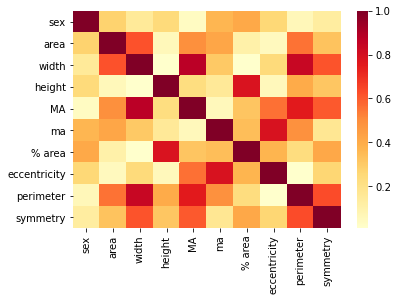

In [5]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
print("Load final data")
display(file_data.head())
#file_data = file_data[file_data['symmetry']>0.65]
file_data_filtered = file_data[file_data['area']>150000]
file_data_filtered = file_data_filtered[file_data['perimeter']>1600]
file_data = shuffle(file_data)
file_data_filtered = shuffle(file_data_filtered)

print(len(file_data),"images loaded and ",len(file_data_filtered),"images filtered")

X = file_data.loc[:, 'sex':'symmetry']
X_filtered = file_data_filtered.loc[:, 'sex':'symmetry']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
y_filtered = file_data_filtered.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[decisionTree], 'classifier__criterion':['mse', 'friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
    
    gs_filtered = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs_filtered.fit(X_train_filtered, y_train_filtered.values.ravel())

    joblib.dump({'gs': gs_filtered}, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model_filtered.joblib_dump'))
    
else:
    #Load last models
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*_model.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']
    #Filtered
    files = glob.glob("*_filtered.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs_filtered = models['gs']

# Evaluate best model

In [6]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_r2', ascending=False, inplace=True)
display((mejores_resultados_por_tipo_de_modelo).round(4))
#Evaluate best model (test data)
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained variance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

Best model: DecisionTreeRegressor(criterion='mae', max_features='auto')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,std_test_r2,std_test_explained_variance,std_test_max_error
param_classifier,,,,,,
DecisionTreeRegressor,0.9330,0.9337,-8.6500,0.0458,0.0456,3.0346
LassoLarsCV,0.6644,0.6674,-9.2998,0.0617,0.0591,1.1050
LinearRegression,0.6643,0.6674,-9.3020,0.0617,0.0591,1.1073
LassoCV,0.6643,0.6673,-9.2201,0.0672,0.0627,1.1057
RidgeCV,0.6636,0.6667,-9.0952,0.0607,0.0578,0.9896
Ridge,0.6557,0.6589,-8.7602,0.0625,0.0585,0.7927
Lasso,0.5207,0.5548,-8.2139,0.1634,0.0950,2.4921
LassoLars,0.5206,0.5547,-8.7199,0.1627,0.0946,2.4571


R2 score: 0.9840130841418689
Explained variance score: 0.9840176619628858
Max error: 6.600000000000001
Mean absolute error: 0.10912343470483006


[{'dd40ff8d4742498eae031adbb8a07c3b': 2.5}, {'76d238facee64b459a90b542b864aa77': 4.399999999999999}, {'ca45b9ef902b44cabf4718929844ac20': 6.600000000000001}, {'921bb3ec168c442295908421495f474b': 2.5}, {'1ef33987e4b042569954ed1b281d1234': 2.6000000000000014}, {'21785afde8df45d8a191b3d55a0257b1': 3.0}, {'23a66c65f98840dfa30316de2dd92db1': 2.900000000000002}, {'1381e4b756a7402e9e5c99c7cf758688': 3.0}, {'ca61cb45adbd4c3a9ee4166d7c014a71': 6.299999999999999}, {'9f8d9e4a6c0e4d2b8e5ec8ff9ade0338': 4.399999999999999}, {'65c7d3b5545744a09ece22a24c8ee477': 3.8000000000000007}]


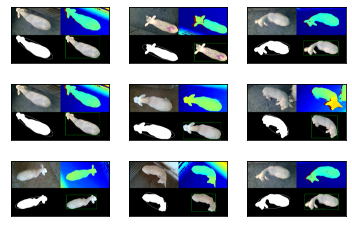

In [7]:
if PROCESS_DATA:
    files = []
    differences = []
    for i in range(0,len(best_estimator_predictions)):
        difference = abs(best_estimator_predictions[i]-y_test.iloc[i].weight) 
        if difference>2:
            uuid = file_data.loc[y_test.iloc[i].name].uuid
            files.append(uuid)
            differences.append({uuid:difference})
    print(differences)


    max_images = 9 if (len(files)>9)  else len(files)
    for i in range(0,max_images):
        plt.subplot(3,3,i+1)
        img=mpimg.imread(os.path.join("..", 'data', 'mosaic', files[i]+'_mosaico.png'))
        plt.imshow(img)
        plt.xticks([]),plt.yticks([])

    plt.savefig(os.path.join("..", 'data', 'mismatch.jpeg'), bbox_inches='tight')

# Evaluate best model filtered

In [8]:
best_estimator_filtered = gs_filtered.best_estimator_
print('Best model:', best_estimator_filtered.named_steps.classifier)

resultados_filtered = pd.DataFrame(gs_filtered.cv_results_)
resultados_filtered['param_classifier'] = resultados_filtered.param_classifier.astype(str).str.split('(', expand=True)[0]
mejores_resultados_por_tipo_de_modelo_filtered = pd.pivot_table(data=resultados_filtered,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 
                             'mean_test_neg_root_mean_squared_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 
                         'std_test_r2', 'std_test_explained_variance', 'std_test_max_error'], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo_filtered.sort_values(by='mean_test_r2', ascending=False, inplace=True)
display((mejores_resultados_por_tipo_de_modelo_filtered).round(4))
#Evaluate best model (test data)
best_estimator_predictions_filtered = best_estimator_filtered.predict(X_test_filtered)
print('R2 score:', r2_score(y_test_filtered, best_estimator_predictions_filtered))
print('Explained variance score:', explained_variance_score(y_test_filtered, best_estimator_predictions_filtered))
print('Max error:', max_error(y_test_filtered, best_estimator_predictions_filtered))
print('Mean absolute error:', mean_absolute_error(y_test_filtered, best_estimator_predictions_filtered))

Best model: DecisionTreeRegressor(criterion='mae', max_features='auto')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,std_test_r2,std_test_explained_variance,std_test_max_error
param_classifier,,,,,,
DecisionTreeRegressor,0.9641,0.9643,-5.6500,0.0402,0.0398,2.9705
LassoLarsCV,0.8346,0.8368,-6.6224,0.0587,0.0598,1.3321
LinearRegression,0.8346,0.8367,-6.6260,0.0587,0.0598,1.3345
LassoCV,0.8343,0.8366,-6.5437,0.0494,0.0514,1.3265
RidgeCV,0.8329,0.8354,-6.5147,0.0551,0.0564,1.3613
Ridge,0.8198,0.8230,-6.4717,0.0489,0.0505,1.4258
Lasso,0.5722,0.6140,-7.7223,0.2071,0.0970,1.2093
LassoLars,0.5715,0.6133,-8.4370,0.2071,0.0969,1.2078


R2 score: 0.9863284590917069
Explained variance score: 0.9863532697430292
Max error: 5.299999999999997
Mean absolute error: 0.08770053475935824
